In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import util
import util_mnist

In [8]:
import sys
import os

import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk

from mpl_toolkits import mplot3d

# Voxel data

In [58]:
X = util.getAll("chair")
X = util.np.expand_dims(X, 4)

In [59]:
train_bf = util.BatchFeeder(X, batch_size=128)

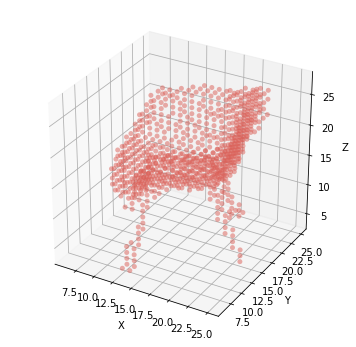

In [60]:
util.plotVoxel(train_bf.next()[0])

# MNIST data

In [25]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000, 28, 28, 1)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

train_bf = util_mnist.BatchFeeder(X[index[:54000]], Y[index[:54000]], 128)
valid_bf = util_mnist.BatchFeeder(X[index[54000:]], Y[index[54000:]], 32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Decoders and Encoders

In [149]:
def generator(_input, bn, dims, fn, filtersize, outfn=tf.tanh, reuse=None):
    with tf.variable_scope("generator", reuse=reuse):

        # Maping from latenet to some dimension with fully connected layer.
        net = tf.contrib.slim.fully_connected(_input, 2*2*2*dims[0], activation_fn=None) 
        net = tf.contrib.layers.batch_norm(net, is_training=bn)
        net = tf.nn.relu(net)
        net = tf.reshape(net, [-1, 2, 2, 2, dims[0]])

        n_filt = dims[1]
        layer2 = tf.layers.conv3d_transpose(net, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
        layer2 = fn(layer2)
        
        n_filt = dims[2]
        layer3 = tf.layers.conv3d_transpose(layer2, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer3 = tf.contrib.layers.batch_norm(layer3, is_training=bn)
        layer3 = fn(layer3)

        n_filt = dims[3]
        layer4 = tf.layers.conv3d_transpose(layer3, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer4 = tf.contrib.layers.batch_norm(layer4, is_training=bn)
        layer4 = fn(layer4)

        n_filt = 1
        layer5 = tf.layers.conv3d_transpose(layer4, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer5 = tf.contrib.layers.batch_norm(layer5, is_training=bn)
        layer5 = outfn(layer5)      

        return layer5

In [150]:
def discriminator(_input, bn, dims, fn, filtersize, outputsize, outfn=tf.identity, reuse=None):
    with tf.variable_scope("discriminator", reuse=reuse):

        n_filt = dims[-1]
        layer1 = tf.layers.conv3d(_input, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer1 = tf.contrib.layers.batch_norm(layer1, is_training=bn)
        layer1 = fn(layer1)

        n_filt = dims[-2]
        layer2 = tf.layers.conv3d(layer1, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
        layer2 = fn(layer2)

        n_filt = dims[-3]
        layer3 = tf.layers.conv3d(layer2, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer3 = tf.contrib.layers.batch_norm(layer3, is_training=bn)
        layer3 = fn(layer3)

        n_filt = dims[-4]
        layer4 = tf.layers.conv3d(layer3, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer4 = tf.contrib.layers.batch_norm(layer4, is_training=bn)
        layer4 = fn(layer4)

        layer5 = tf.layers.flatten(layer4)
        layer5 = tf.contrib.slim.fully_connected(layer5, outputsize, activation_fn=tf.identity)
        layer5 = outfn(layer5)

        return layer5

In [151]:
def encoder(_input, bn, dims, fn, filtersize, reuse=None):
    with tf.variable_scope("encoder", reuse=reuse):

        n_filt = dims[-1]
        layer1 = tf.layers.conv3d(_input, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer1 = tf.contrib.layers.batch_norm(layer1, is_training=bn)
        layer1 = fn(layer1)

        n_filt = dims[-2]
        layer2 = tf.layers.conv3d(layer1, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
        layer2 = fn(layer2)

        n_filt = dims[-3]
        layer3 = tf.layers.conv3d(layer2, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer3 = tf.contrib.layers.batch_norm(layer3, is_training=bn)
        layer3 = fn(layer3)

        n_filt = dims[-4]
        layer4 = tf.layers.conv3d(layer3, n_filt, filtersize, strides=(2,2,2), padding="same", activation=None)
        layer4 = tf.contrib.layers.batch_norm(layer4, is_training=bn)
        layer4 = fn(layer4)

        layer5 = tf.layers.flatten(layer4)
        mus = tf.contrib.slim.fully_connected(layer5, 200, activation_fn=tf.identity)
        sigmas = tf.contrib.slim.fully_connected(layer5, 200, activation_fn=tf.tanh)

        return mus, sigmas

# GAN Model

In [166]:
class GAN:
    def __init__(self):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Define parameters of the encoder
        self.input_dim = (32, 32, 32, 1)
        
        # Dimension of the sub-netowrks.
        self.latent_dim = 200
        self.batchsize = 128
        self.filtersize = [4, 4, 4]
        
        # Dims
        self.dims = [256, 128, 64, 32]
        
        # Activation functions
        
        # Other parameters
        self.learning_rate = 0.001
        self.g_lr = 0.002 # 0.0025
        self.d_lr = 0.001 # 1e-5
        
        # Build netowrk
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        
        # Tracking data
        self.learning_curve = []
        self.record = {"generated":[]}
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
    
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
        
        #### INPUTS to the network #####
        
        x = tf.placeholder(tf.float32, shape=[self.batchsize]+list(self.input_dim), name="x")
        z = tf.random_normal([self.batchsize, self.latent_dim], 0, 1)
        eps = tf.random_normal([self.batchsize, self.latent_dim], 0, 1)
        bn = tf.placeholder(tf.bool, shape=[])
        
        #### Network configuration ####
        # VAE part #
        mus, sigmas = encoder(x, bn, self.dims, tf.nn.relu, self.filtersize)
        z_x = tf.add(mus,  tf.multiply(sigmas, eps))
        gz_vae = generator(z_x, bn, self.dims, tf.nn.relu, self.filtersize)
        
        # GAN part #
        gz_gan = generator(z, bn, self.dims, tf.nn.relu, self.filtersize, reuse=True)
        dgz_gan = discriminator(gz_gan, bn, self.dims, tf.nn.relu, self.filtersize, 32)
        dx_gan = discriminator(x, bn, self.dims, tf.nn.relu, self.filtersize, 32, reuse=True)
        assert gz_gan.shape == x.shape
        
        #### Gradient penalty calculations ####
        alpha = tf.random_uniform(shape=[self.batchsize, 1], minval=0., maxval=1.)
        difference = gz_gan - x
        inter = []
        for i in range(self.batchsize):
            inter.append(difference[i]*alpha[i])
        inter = tf.unstack(inter)
        interpolates        = x + inter
        gradients           = tf.gradients(discriminator(interpolates, bn, self.dims, tf.nn.relu, self.filtersize, 32, reuse=True),[interpolates])[0]
        slopes              = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
        gradient_penalty    = tf.reduce_mean((slopes-1.)**2.)
        
        #### Loss calculations ####
        kl_loss             = tf.reduce_mean(-sigmas +.5*(-1.+tf.exp(2.*sigmas)+tf.square(mus)))  
        recon_loss          = tf.reduce_mean(tf.square(x-gz_vae))/2.
        d_loss              = -tf.reduce_mean(dx_gan) + tf.reduce_mean(dgz_gan) + 10.*gradient_penalty
        g_loss              = -tf.reduce_mean(dgz_gan)+(5)*recon_loss
        v_loss              = kl_loss + recon_loss
        
        # Optimization
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            g_vars = [v for v in tf.trainable_variables() if "generator" in v.name]
            d_vars = [v for v in tf.trainable_variables() if "discriminator" in v.name]
            v_vars = [v for v in tf.trainable_variables() if "encoder" in v.name]
            
            g_optim = tf.train.AdamOptimizer( learning_rate = 1e-4, beta1=0.5, beta2=0.9).minimize(g_loss, var_list=g_vars)
            d_optim = tf.train.AdamOptimizer( learning_rate = 1e-4, beta1=0.5, beta2=0.9).minimize(d_loss, var_list=d_vars)
            v_optim = tf.train.AdamOptimizer( learning_rate = 1e-4, beta1=0.5, beta2=0.9).minimize(v_loss, var_list=v_vars)
            
        # Building independent generator
        z_ = tf.placeholder_with_default(tf.random_normal([self.batchsize, self.latent_dim]),
                                            shape=[self.batchsize, self.latent_dim],
                                            name="latent_input")
        gz_ = generator(z, bn, self.dims, tf.nn.relu, self.filtersize, reuse=True)
        
        # Exporting out the operaions as dictionary
        return dict(
            x = x,
            z = z,
            generated = gz_gan,
            z_ = z_,
            generated_ = gz_,
            d_loss = d_loss,
            g_loss = g_loss,
            v_loss = v_loss,
            recon_loss = recon_loss,
            d_optim = d_optim,
            g_optim = g_optim,
            v_optim = v_optim,
            bn = bn
        )
        
    def decode(self, z=None):
        feed_dict = dict()
        if z is not None:
            feed_dict = {self.ops["z_"]: z, self.ops["bn"]: False}
        else:
            feed_dict = {self.ops["bn"]: False}
        return self.sesh.run(self.ops["generated_"], feed_dict)
        
    def train(self, X, epochs):
        # Making the saver object.
        saver = tf.train.Saver()
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X.n*1.0/X.batch_size))
        
        e = 0
        while e < epochs:
            epoch_cost = {"dloss":[], "gloss":[]}
            
            if e == epochs-1: self.latent_record = {"generated":[]}
            
            for i in range(batch_num):
                batch = X.next()
                feed_dict = {self.ops["x"]: batch, self.ops["bn"]: True}
                
                # Training discriminator and VAE
                _ops = [self.ops["d_loss"],
                       self.ops["d_optim"],
                       self.ops["v_loss"],
                       self.ops["v_optim"],
                       self.ops["recon_loss"]]
                errD, _, errV, _, r_loss = self.sesh.run(_ops, feed_dict)
                
                _ops = [self.ops["g_loss"],
                       self.ops["g_optim"],
                       self.ops["recon_loss"]]
                if i%5==0:
                    errG, _, r_loss = self.sesh.run(_ops, feed_dict)
                    
                generated = self.sesh.run(self.ops["generated"], feed_dict)
                if e == epochs-1: self.record["generated"] = self.record["generated"] + [_ for _ in generated]
                
                print("d_loss: %.4f, g_loss: %.4f, v_loss: %.4f, r_loss: %.4f" 
                      % (errD, errG, errV, r_loss))      
                sys.stdout.flush()
            
            
            self.e+=1
            e+= 1

In [167]:
m = GAN()

In [176]:
m.train(train_bf, 20)

d_loss: -395.5383, g_loss: 196.5505, v_loss: 0.0259, r_loss: 0.0222
d_loss: -395.6134, g_loss: 196.5505, v_loss: 0.0243, r_loss: 0.0220
d_loss: -395.8962, g_loss: 196.5505, v_loss: 0.0234, r_loss: 0.0222
d_loss: -396.4565, g_loss: 196.5505, v_loss: 0.0336, r_loss: 0.0285
d_loss: -396.8419, g_loss: 196.5505, v_loss: 0.0313, r_loss: 0.0275
d_loss: -396.9982, g_loss: 197.0905, v_loss: 0.0263, r_loss: 0.0219
d_loss: -397.0616, g_loss: 197.0905, v_loss: 0.0227, r_loss: 0.0209
d_loss: -397.1237, g_loss: 197.0905, v_loss: 0.0226, r_loss: 0.0211
d_loss: -397.7884, g_loss: 197.0905, v_loss: 0.0198, r_loss: 0.0178
d_loss: -397.8914, g_loss: 197.0905, v_loss: 0.0262, r_loss: 0.0242
d_loss: -398.2159, g_loss: 197.8879, v_loss: 0.0668, r_loss: 0.0636
d_loss: -397.6768, g_loss: 197.8879, v_loss: 0.0499, r_loss: 0.0269
d_loss: -398.4529, g_loss: 197.8879, v_loss: 0.0582, r_loss: 0.0320
d_loss: -398.7229, g_loss: 197.8879, v_loss: 0.0444, r_loss: 0.0265
d_loss: -399.0761, g_loss: 197.8879, v_loss: 0.0

d_loss: -424.1783, g_loss: 210.4225, v_loss: 0.0287, r_loss: 0.0263
d_loss: -424.7337, g_loss: 210.4225, v_loss: 0.0296, r_loss: 0.0267
d_loss: -424.7775, g_loss: 210.4225, v_loss: 0.0269, r_loss: 0.0251
d_loss: -425.1795, g_loss: 211.0075, v_loss: 0.0275, r_loss: 0.0251
d_loss: -425.2463, g_loss: 211.0075, v_loss: 0.0195, r_loss: 0.0184
d_loss: -425.7177, g_loss: 211.0075, v_loss: 0.0197, r_loss: 0.0186
d_loss: -425.9612, g_loss: 211.0075, v_loss: 0.0489, r_loss: 0.0479
d_loss: -425.9881, g_loss: 211.0075, v_loss: 0.0472, r_loss: 0.0232
d_loss: -426.2800, g_loss: 211.4753, v_loss: 0.0635, r_loss: 0.0331
d_loss: -426.2581, g_loss: 211.4753, v_loss: 0.0484, r_loss: 0.0248
d_loss: -426.7390, g_loss: 211.4753, v_loss: 0.0361, r_loss: 0.0217
d_loss: -426.9916, g_loss: 211.4753, v_loss: 0.0327, r_loss: 0.0263
d_loss: -427.0749, g_loss: 211.4753, v_loss: 0.0303, r_loss: 0.0254
d_loss: -427.6158, g_loss: 212.1725, v_loss: 0.0295, r_loss: 0.0243
d_loss: -427.8224, g_loss: 212.1725, v_loss: 0.0

d_loss: -452.9649, g_loss: 222.7704, v_loss: 0.0393, r_loss: 0.0311
d_loss: -453.1980, g_loss: 224.8043, v_loss: 0.0324, r_loss: 0.0264
d_loss: -453.2604, g_loss: 224.8043, v_loss: 0.0299, r_loss: 0.0264
d_loss: -453.8862, g_loss: 224.8043, v_loss: 0.0248, r_loss: 0.0220
d_loss: -454.0941, g_loss: 224.8043, v_loss: 0.0421, r_loss: 0.0408
d_loss: -454.5319, g_loss: 224.8043, v_loss: 0.0320, r_loss: 0.0272
d_loss: -454.7803, g_loss: 225.5813, v_loss: 0.0310, r_loss: 0.0235
d_loss: -455.0817, g_loss: 225.5813, v_loss: 0.0307, r_loss: 0.0265
d_loss: -455.3462, g_loss: 225.5813, v_loss: 0.0270, r_loss: 0.0250
d_loss: -455.5977, g_loss: 225.5813, v_loss: 0.0302, r_loss: 0.0289
d_loss: -455.7493, g_loss: 226.0715, v_loss: 0.0299, r_loss: 0.0267
d_loss: -455.7684, g_loss: 226.0715, v_loss: 0.0315, r_loss: 0.0279
d_loss: -456.3092, g_loss: 226.0715, v_loss: 0.0285, r_loss: 0.0266
d_loss: -456.4427, g_loss: 226.0715, v_loss: 0.0245, r_loss: 0.0233
d_loss: -456.6719, g_loss: 226.0715, v_loss: 0.0

d_loss: -481.5364, g_loss: 238.8267, v_loss: 0.0303, r_loss: 0.0264
d_loss: -481.8536, g_loss: 238.8267, v_loss: 0.0262, r_loss: 0.0244
d_loss: -482.2527, g_loss: 238.8267, v_loss: 0.0204, r_loss: 0.0185
d_loss: -482.5643, g_loss: 239.4302, v_loss: 0.0221, r_loss: 0.0192
d_loss: -482.7946, g_loss: 239.4302, v_loss: 0.0615, r_loss: 0.0593
d_loss: -483.1289, g_loss: 239.4302, v_loss: 0.0430, r_loss: 0.0310
d_loss: -483.5278, g_loss: 239.4302, v_loss: 0.0373, r_loss: 0.0249
d_loss: -483.6027, g_loss: 239.4302, v_loss: 0.0294, r_loss: 0.0217
d_loss: -483.9394, g_loss: 240.1490, v_loss: 0.0368, r_loss: 0.0300
d_loss: -483.9387, g_loss: 240.1490, v_loss: 0.0298, r_loss: 0.0276
d_loss: -484.3123, g_loss: 240.1490, v_loss: 0.0266, r_loss: 0.0226
d_loss: -484.6260, g_loss: 240.1490, v_loss: 0.0249, r_loss: 0.0222
d_loss: -484.4843, g_loss: 240.1490, v_loss: 0.0265, r_loss: 0.0240
d_loss: -485.0923, g_loss: 240.5582, v_loss: 0.0250, r_loss: 0.0221
d_loss: -485.1451, g_loss: 240.5582, v_loss: 0.0

d_loss: -509.4908, g_loss: 253.0457, v_loss: 0.0442, r_loss: 0.0217
d_loss: -509.9416, g_loss: 253.6557, v_loss: 0.0433, r_loss: 0.0275
d_loss: -511.2644, g_loss: 253.6557, v_loss: 0.0337, r_loss: 0.0225
d_loss: -511.7144, g_loss: 253.6557, v_loss: 0.0364, r_loss: 0.0315
d_loss: -512.3013, g_loss: 253.6557, v_loss: 0.0292, r_loss: 0.0257
d_loss: -512.2796, g_loss: 253.6557, v_loss: 0.0276, r_loss: 0.0228
d_loss: -512.7657, g_loss: 254.3148, v_loss: 0.0289, r_loss: 0.0259
d_loss: -513.1295, g_loss: 254.3148, v_loss: 0.0274, r_loss: 0.0250
d_loss: -513.2056, g_loss: 254.3148, v_loss: 0.0293, r_loss: 0.0256
d_loss: -513.4362, g_loss: 254.3148, v_loss: 0.0225, r_loss: 0.0191
d_loss: -513.2915, g_loss: 254.3148, v_loss: 0.0285, r_loss: 0.0259
d_loss: -513.8967, g_loss: 254.8204, v_loss: 0.0252, r_loss: 0.0230
d_loss: -513.1317, g_loss: 254.8204, v_loss: 0.0202, r_loss: 0.0194
d_loss: -512.0044, g_loss: 254.8204, v_loss: 0.0265, r_loss: 0.0229
d_loss: -513.0733, g_loss: 254.8204, v_loss: 0.0

d_loss: -540.8198, g_loss: 267.8703, v_loss: 0.0347, r_loss: 0.0338
d_loss: -541.2469, g_loss: 267.8703, v_loss: 0.0396, r_loss: 0.0235
d_loss: -541.3263, g_loss: 267.8703, v_loss: 0.0421, r_loss: 0.0263
d_loss: -541.8184, g_loss: 268.4737, v_loss: 0.0332, r_loss: 0.0239
d_loss: -541.9537, g_loss: 268.4737, v_loss: 0.0262, r_loss: 0.0205
d_loss: -541.4720, g_loss: 268.4737, v_loss: 0.0309, r_loss: 0.0260
d_loss: -541.8598, g_loss: 268.4737, v_loss: 0.0291, r_loss: 0.0274
d_loss: -542.5672, g_loss: 268.4737, v_loss: 0.0287, r_loss: 0.0249
d_loss: -542.6470, g_loss: 269.1077, v_loss: 0.0284, r_loss: 0.0239
d_loss: -543.0769, g_loss: 269.1077, v_loss: 0.0280, r_loss: 0.0255
d_loss: -543.2308, g_loss: 269.1077, v_loss: 0.0249, r_loss: 0.0223
d_loss: -543.5040, g_loss: 269.1077, v_loss: 0.0244, r_loss: 0.0214
d_loss: -543.7539, g_loss: 269.1077, v_loss: 0.0205, r_loss: 0.0196
d_loss: -543.9623, g_loss: 269.6463, v_loss: 0.0256, r_loss: 0.0225
d_loss: -543.7650, g_loss: 269.6463, v_loss: 0.0

d_loss: -570.7512, g_loss: 282.5914, v_loss: 0.0214, r_loss: 0.0188
d_loss: -571.4857, g_loss: 283.1667, v_loss: 0.0218, r_loss: 0.0196
d_loss: -571.5601, g_loss: 283.1667, v_loss: 0.0205, r_loss: 0.0192
d_loss: -571.8640, g_loss: 283.1667, v_loss: 0.0191, r_loss: 0.0181
d_loss: -572.0653, g_loss: 283.1667, v_loss: 0.0221, r_loss: 0.0213
d_loss: -571.3041, g_loss: 283.1667, v_loss: 0.0194, r_loss: 0.0176
d_loss: -571.3962, g_loss: 283.7045, v_loss: 0.0212, r_loss: 0.0207
d_loss: -572.5327, g_loss: 283.7045, v_loss: 0.0228, r_loss: 0.0193
d_loss: -572.6625, g_loss: 283.7045, v_loss: 0.0361, r_loss: 0.0332
d_loss: -573.2059, g_loss: 283.7045, v_loss: 0.0319, r_loss: 0.0216
d_loss: -573.5612, g_loss: 283.7045, v_loss: 0.0351, r_loss: 0.0243
d_loss: -573.9114, g_loss: 284.3322, v_loss: 0.0284, r_loss: 0.0206
d_loss: -574.2285, g_loss: 284.3322, v_loss: 0.0268, r_loss: 0.0232
d_loss: -574.3448, g_loss: 284.3322, v_loss: 0.0311, r_loss: 0.0291
d_loss: -574.4209, g_loss: 284.3322, v_loss: 0.0

d_loss: -601.8337, g_loss: 297.7621, v_loss: 0.0249, r_loss: 0.0234
d_loss: -601.9841, g_loss: 297.7621, v_loss: 0.0223, r_loss: 0.0211
d_loss: -601.9489, g_loss: 297.7621, v_loss: 0.0205, r_loss: 0.0196
d_loss: -602.4730, g_loss: 298.3114, v_loss: 0.0225, r_loss: 0.0201
d_loss: -602.7146, g_loss: 298.3114, v_loss: 0.0575, r_loss: 0.0562
d_loss: -603.1206, g_loss: 298.3114, v_loss: 0.0414, r_loss: 0.0199
d_loss: -603.0718, g_loss: 298.3114, v_loss: 0.0697, r_loss: 0.0435
d_loss: -603.4329, g_loss: 298.3114, v_loss: 0.0523, r_loss: 0.0316
d_loss: -603.5493, g_loss: 298.1172, v_loss: 0.0366, r_loss: 0.0219
d_loss: -601.5612, g_loss: 298.1172, v_loss: 0.0337, r_loss: 0.0235
d_loss: -603.6622, g_loss: 298.1172, v_loss: 0.0255, r_loss: 0.0190
d_loss: -604.0876, g_loss: 298.1172, v_loss: 0.0280, r_loss: 0.0230
d_loss: -604.6414, g_loss: 298.1172, v_loss: 0.0251, r_loss: 0.0226
d_loss: -605.0826, g_loss: 299.7621, v_loss: 0.0236, r_loss: 0.0212
d_loss: -604.9979, g_loss: 299.7621, v_loss: 0.0

d_loss: -632.7915, g_loss: 312.8786, v_loss: 0.0213, r_loss: 0.0181
d_loss: -633.1176, g_loss: 313.5581, v_loss: 0.0223, r_loss: 0.0197
d_loss: -633.3332, g_loss: 313.5581, v_loss: 0.0228, r_loss: 0.0210
d_loss: -631.8967, g_loss: 313.5581, v_loss: 0.0195, r_loss: 0.0177
d_loss: -633.5499, g_loss: 313.5581, v_loss: 0.0488, r_loss: 0.0474
d_loss: -633.9528, g_loss: 313.5581, v_loss: 0.0641, r_loss: 0.0474
d_loss: -634.2021, g_loss: 314.1792, v_loss: 0.0427, r_loss: 0.0205
d_loss: -634.6608, g_loss: 314.1792, v_loss: 0.0402, r_loss: 0.0219
d_loss: -633.2098, g_loss: 314.1792, v_loss: 0.0362, r_loss: 0.0246
d_loss: -634.9209, g_loss: 314.1792, v_loss: 0.0325, r_loss: 0.0254
d_loss: -634.9901, g_loss: 314.1792, v_loss: 0.0308, r_loss: 0.0263
d_loss: -635.4553, g_loss: 314.6637, v_loss: 0.0234, r_loss: 0.0194
d_loss: -635.7498, g_loss: 314.6637, v_loss: 0.0293, r_loss: 0.0276
d_loss: -635.3607, g_loss: 314.6637, v_loss: 0.0235, r_loss: 0.0200
d_loss: -635.8286, g_loss: 314.6637, v_loss: 0.0

d_loss: -663.9778, g_loss: 328.7225, v_loss: 0.0409, r_loss: 0.0238
d_loss: -664.2556, g_loss: 328.7225, v_loss: 0.0302, r_loss: 0.0201
d_loss: -664.6308, g_loss: 328.7225, v_loss: 0.0317, r_loss: 0.0265
d_loss: -664.3257, g_loss: 329.1553, v_loss: 0.0260, r_loss: 0.0220
d_loss: -664.6242, g_loss: 329.1553, v_loss: 0.0255, r_loss: 0.0239
d_loss: -664.8671, g_loss: 329.1553, v_loss: 0.0248, r_loss: 0.0231
d_loss: -665.3986, g_loss: 329.1553, v_loss: 0.0241, r_loss: 0.0232
d_loss: -665.8525, g_loss: 329.1553, v_loss: 0.0225, r_loss: 0.0198
d_loss: -666.1037, g_loss: 329.9108, v_loss: 0.0247, r_loss: 0.0220
d_loss: -666.3633, g_loss: 329.9108, v_loss: 0.0236, r_loss: 0.0217
d_loss: -666.4907, g_loss: 329.9108, v_loss: 0.0235, r_loss: 0.0221
d_loss: -666.6273, g_loss: 329.9108, v_loss: 0.0225, r_loss: 0.0205
d_loss: -667.0044, g_loss: 329.9108, v_loss: 0.0297, r_loss: 0.0291
d_loss: -667.3414, g_loss: 330.3003, v_loss: 0.0344, r_loss: 0.0251
d_loss: -667.5204, g_loss: 330.3003, v_loss: 0.0

d_loss: -695.5379, g_loss: 343.9832, v_loss: 0.0225, r_loss: 0.0205
d_loss: -695.6965, g_loss: 344.6259, v_loss: 0.0216, r_loss: 0.0204
d_loss: -695.6371, g_loss: 344.6259, v_loss: 0.0592, r_loss: 0.0556
d_loss: -696.3198, g_loss: 344.6259, v_loss: 0.0386, r_loss: 0.0202
d_loss: -696.7238, g_loss: 344.6259, v_loss: 0.0396, r_loss: 0.0193
d_loss: -696.9003, g_loss: 344.6259, v_loss: 0.0326, r_loss: 0.0184
d_loss: -697.1013, g_loss: 345.0728, v_loss: 0.0532, r_loss: 0.0340
d_loss: -696.4238, g_loss: 345.0728, v_loss: 0.0287, r_loss: 0.0205
d_loss: -697.4205, g_loss: 345.0728, v_loss: 0.0295, r_loss: 0.0222
d_loss: -697.8987, g_loss: 345.0728, v_loss: 0.0254, r_loss: 0.0203
d_loss: -697.4523, g_loss: 345.0728, v_loss: 0.0219, r_loss: 0.0180
d_loss: -698.1253, g_loss: 345.6198, v_loss: 0.0242, r_loss: 0.0220
d_loss: -696.8463, g_loss: 345.6198, v_loss: 0.0234, r_loss: 0.0218
d_loss: -685.9384, g_loss: 345.6198, v_loss: 0.0211, r_loss: 0.0196
d_loss: -693.0743, g_loss: 345.6198, v_loss: 0.0

d_loss: -724.8474, g_loss: 359.4848, v_loss: 0.0218, r_loss: 0.0188
d_loss: -724.1917, g_loss: 359.4848, v_loss: 0.0247, r_loss: 0.0225
d_loss: -726.1747, g_loss: 359.4848, v_loss: 0.0234, r_loss: 0.0214
d_loss: -726.2368, g_loss: 359.4848, v_loss: 0.0197, r_loss: 0.0178
d_loss: -725.8417, g_loss: 360.2495, v_loss: 0.0414, r_loss: 0.0423
d_loss: -726.2643, g_loss: 360.2495, v_loss: 0.0412, r_loss: 0.0205
d_loss: -726.8754, g_loss: 360.2495, v_loss: 0.0445, r_loss: 0.0181
d_loss: -727.6242, g_loss: 360.2495, v_loss: 0.0406, r_loss: 0.0209
d_loss: -728.0173, g_loss: 360.2495, v_loss: 0.0343, r_loss: 0.0216
d_loss: -728.5385, g_loss: 360.8962, v_loss: 0.0263, r_loss: 0.0187
d_loss: -728.1749, g_loss: 360.8962, v_loss: 0.0252, r_loss: 0.0215
d_loss: -728.2370, g_loss: 360.8962, v_loss: 0.0264, r_loss: 0.0236
d_loss: -725.6351, g_loss: 360.8962, v_loss: 0.0239, r_loss: 0.0218
d_loss: -687.2845, g_loss: 358.4538, v_loss: 0.0276, r_loss: 0.0224
d_loss: -700.1884, g_loss: 358.4538, v_loss: 0.0

d_loss: -758.9350, g_loss: 374.9133, v_loss: 0.0276, r_loss: 0.0253
d_loss: -759.3144, g_loss: 376.0919, v_loss: 0.0237, r_loss: 0.0204
d_loss: -759.6924, g_loss: 376.0919, v_loss: 0.0260, r_loss: 0.0246
d_loss: -759.9200, g_loss: 376.0919, v_loss: 0.0210, r_loss: 0.0193
d_loss: -760.2717, g_loss: 376.0919, v_loss: 0.0255, r_loss: 0.0245
d_loss: -760.6744, g_loss: 376.0919, v_loss: 0.0262, r_loss: 0.0225
d_loss: -760.8254, g_loss: 376.6608, v_loss: 0.0242, r_loss: 0.0214
d_loss: -760.8969, g_loss: 376.6608, v_loss: 0.0218, r_loss: 0.0201
d_loss: -760.4549, g_loss: 376.6608, v_loss: 0.0209, r_loss: 0.0193
d_loss: -761.2396, g_loss: 376.6608, v_loss: 0.0434, r_loss: 0.0426
d_loss: -761.4479, g_loss: 376.6608, v_loss: 0.0361, r_loss: 0.0199
d_loss: -762.3472, g_loss: 377.5047, v_loss: 0.0454, r_loss: 0.0231
d_loss: -761.3364, g_loss: 377.5047, v_loss: 0.0404, r_loss: 0.0280
d_loss: -762.5072, g_loss: 377.5047, v_loss: 0.0294, r_loss: 0.0207
d_loss: -761.9849, g_loss: 377.5047, v_loss: 0.0

d_loss: -753.6006, g_loss: 389.5320, v_loss: 0.0213, r_loss: 0.0189
d_loss: -790.4055, g_loss: 389.5320, v_loss: 0.0198, r_loss: 0.0175
d_loss: -782.5402, g_loss: 389.5320, v_loss: 0.0222, r_loss: 0.0208
d_loss: -791.8629, g_loss: 389.5320, v_loss: 0.0420, r_loss: 0.0412
d_loss: -793.1591, g_loss: 392.7975, v_loss: 0.0357, r_loss: 0.0201
d_loss: -793.5151, g_loss: 392.7975, v_loss: 0.0354, r_loss: 0.0174
d_loss: -793.6870, g_loss: 392.7975, v_loss: 0.0335, r_loss: 0.0221
d_loss: -794.1829, g_loss: 392.7975, v_loss: 0.0303, r_loss: 0.0246
d_loss: -794.8079, g_loss: 392.7975, v_loss: 0.0238, r_loss: 0.0207
d_loss: -795.0591, g_loss: 393.5405, v_loss: 0.0221, r_loss: 0.0199
d_loss: -795.3070, g_loss: 393.5405, v_loss: 0.0264, r_loss: 0.0243
d_loss: -795.3368, g_loss: 393.5405, v_loss: 0.0228, r_loss: 0.0205
d_loss: -795.8406, g_loss: 393.5405, v_loss: 0.0236, r_loss: 0.0223
d_loss: -796.0450, g_loss: 393.5405, v_loss: 0.0219, r_loss: 0.0209
d_loss: -796.4312, g_loss: 394.2015, v_loss: 0.0

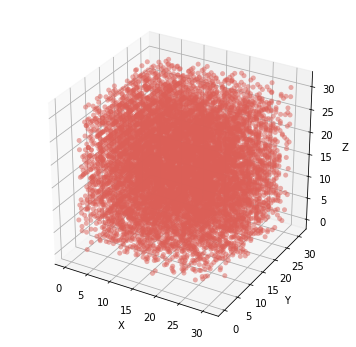

In [177]:
util.plotVoxel(m.record["generated"][np.random.randint(1000)], th=0.4)